## IS453 Financial Analytics
## Week 12 - Credit Scoring Lab

### Credit scorecard performance evaluation and tuning

## HMEQ Dataset

The data set HMEQ reports characteristics and delinquency information for 5,960 home equity loans. A home equity loan is a loan where the obligor uses the equity of his or her home as the underlying collateral. 
The data is originally taken from the Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS book website - https://www.bartbaesens.com/book/6/credit-risk-analytics.
A cleaner version of the data is on Kaggle - https://www.kaggle.com/akhil14shukla/loan-defaulter-prediction/data


**Variables definition**

1. BAD: Binary response variable
    - 1 = applicant defaulted on loan or seriously delinquent; 
    - 0 = applicant paid loan or customer is current on loan payments. This is the class column.
2. LOAN: Requested loan amount
3. MORTDUE: Amount due on existing mortgage
4. VALUE: Value of current property
5. REASON: 
    - DebtCon = debt consolidation(customer uses home equity loan to pay back high interest loans)
    - HomeImp = home improvement
6. JOB: Occupational categories
    - ProfExe
    - Mgr
    - Office
    - Self
    - Sales
    - Other
7. YOJ: Years at present job
8. DEROG: Number of major derogatory reports(issued for loans taken in the past when customer fails to keep up the contract or payback on time).
9. DELINQ: Number of delinquent credit lines
10. CLAGE: Age of oldest credit line in months
11. NINQ: Number of recent credit inquiries
12. CLNO: Number of credit lines
13. DEBTINC: Debt-to-income ratio in percent

**Install scorecardpy**
This is a python version of R package scorecard. The API link has more info :

https://pypi.org/project/scorecardpy/

https://github.com/shichenxie/scorecardpy/

https://cran.r-project.org/web/packages/scorecard/scorecard.pdf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
import warnings
warnings.filterwarnings('ignore')
import scorecardpy as sc
import pprint

In [2]:
# sample code
group_data = pd.read_csv('IS453 Group Assignment - Data.csv')

df_filtered = group_data[group_data['OCCUPATION_TYPE'] == 'Drivers']

In [3]:
df_filtered #18603 rows x 75 columns 

,STATUS,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
13,0,Cash loans,M,Y,N,1,225000.0,918468.0,28966.5,697500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
16,0,Cash loans,M,N,N,0,108000.0,509602.5,26149.5,387000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
24,0,Cash loans,M,Y,N,2,135000.0,247500.0,12703.5,247500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
33,0,Cash loans,M,Y,N,1,360000.0,733315.5,39069.0,679500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
37,0,Cash loans,M,N,Y,0,121500.0,454500.0,15151.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307425,0,Revolving loans,M,Y,Y,2,234000.0,450000.0,22500.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
307432,0,Cash loans,M,N,Y,0,135000.0,840951.0,42934.5,679500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
307446,1,Cash loans,M,N,N,0,270000.0,900000.0,40671.0,900000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307491,0,Cash loans,M,Y,Y,2,90000.0,1078200.0,31522.5,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,7.0


In [4]:
df_filtered_forsc = df_filtered.copy()

In [5]:
# df_filtered_forsc
# after dropping code gender, days1711 rows x 75 columns

# drop irrelevant/ bias variables
# CODE_GENDER
# DAYS_BIRTH

irrelevant_col = ['CODE_GENDER','DAYS_BIRTH']
df_filtered_forsc = df_filtered_forsc.drop(columns = irrelevant_col)

In [6]:
df_filtered_forsc
# 1711 rows × 73 columns

,STATUS,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
13,0,Cash loans,Y,N,1,225000.0,918468.0,28966.5,697500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
16,0,Cash loans,N,N,0,108000.0,509602.5,26149.5,387000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
24,0,Cash loans,Y,N,2,135000.0,247500.0,12703.5,247500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
33,0,Cash loans,Y,N,1,360000.0,733315.5,39069.0,679500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
37,0,Cash loans,N,Y,0,121500.0,454500.0,15151.5,454500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307425,0,Revolving loans,Y,Y,2,234000.0,450000.0,22500.0,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
307432,0,Cash loans,N,Y,0,135000.0,840951.0,42934.5,679500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
307446,1,Cash loans,N,N,0,270000.0,900000.0,40671.0,900000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307491,0,Cash loans,Y,Y,2,90000.0,1078200.0,31522.5,900000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,7.0


# pc_missing analysis

In [7]:
def show_missing(df):
    """Return a Pandas dataframe describing the contents of a source dataframe including missing values."""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'variable': variables, 
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing': missing, 
        'pc_missing': pc_missing
    })    
        
    return output

In [8]:
pd.options.display.max_columns = None


In [9]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [10]:
columns_infoDF = show_missing(df_filtered_forsc)

In [11]:
columns_infoDF

,variable,dtype,count,unique,missing,pc_missing
0,STATUS,int64,18603,2,0,0.00
1,NAME_CONTRACT_TYPE,object,18603,2,0,0.00
2,FLAG_OWN_CAR,object,18603,2,0,0.00
3,FLAG_OWN_REALTY,object,18603,2,0,0.00
4,CNT_CHILDREN,int64,18603,8,0,0.00
5,AMT_INCOME_TOTAL,float64,18603,253,0,0.00
6,AMT_CREDIT,float64,18603,2371,0,0.00
7,AMT_ANNUITY,float64,18603,5642,1,0.01
8,AMT_GOODS_PRICE,float64,18603,396,13,0.07
9,NAME_TYPE_SUITE,object,18603,8,82,0.44


In [82]:
cat_var_df = columns_infoDF[columns_infoDF['unique'] == 1]
cat_var_df.value_counts()

variable          dtype   count  unique  missing  pc_missing
FLAG_DOCUMENT_10  int64   18603  1       0        0.0           1
FLAG_DOCUMENT_12  int64   18603  1       0        0.0           1
FLAG_DOCUMENT_2   int64   18603  1       0        0.0           1
FLAG_DOCUMENT_4   int64   18603  1       0        0.0           1
FLAG_MOBIL        int64   18603  1       0        0.0           1
OCCUPATION_TYPE   object  18603  1       0        0.0           1
dtype: int64

In [81]:
cat_var_df = columns_infoDF[columns_infoDF['dtype'] == 'object']
cat_var_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 37
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   variable    11 non-null     object 
 1   dtype       11 non-null     object 
 2   count       11 non-null     int64  
 3   unique      11 non-null     int64  
 4   missing     11 non-null     int64  
 5   pc_missing  11 non-null     float64
dtypes: float64(1), int64(3), object(2)
memory usage: 616.0+ bytes


In [12]:
# all Categorical variables ==> 11

cat_var_df = columns_infoDF[columns_infoDF['dtype'] == 'object']
cat_var_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 37
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   variable    11 non-null     object 
 1   dtype       11 non-null     object 
 2   count       11 non-null     int64  
 3   unique      11 non-null     int64  
 4   missing     11 non-null     int64  
 5   pc_missing  11 non-null     float64
dtypes: float64(1), int64(3), object(2)
memory usage: 616.0+ bytes


In [13]:
# categorical variables's  list
cat_var_list = list(cat_var_df['variable'])
# cat_var_list

In [14]:
# all Continuous variables => 62

cont_var_df = columns_infoDF[columns_infoDF['dtype'] != 'object' ]
cont_var_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 72
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   variable    62 non-null     object 
 1   dtype       62 non-null     object 
 2   count       62 non-null     int64  
 3   unique      62 non-null     int64  
 4   missing     62 non-null     int64  
 5   pc_missing  62 non-null     float64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ KB


In [15]:
# continous variables's  list
cont_var_list = list(cont_var_df['variable'])
# cont_var_list

**Scorecardpy requires an older version of pandas to be able to accomodate missing values**

So remove missing values for now to be able to test out scorecardpy

In [16]:
# sample code
df_filtered_forsc.dropna(inplace=True)
df_filtered_forsc.isna().sum()

STATUS                         0
NAME_CONTRACT_TYPE             0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
REGION_POPULATION_RELATIVE     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
OWN_CAR_AGE                    0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_

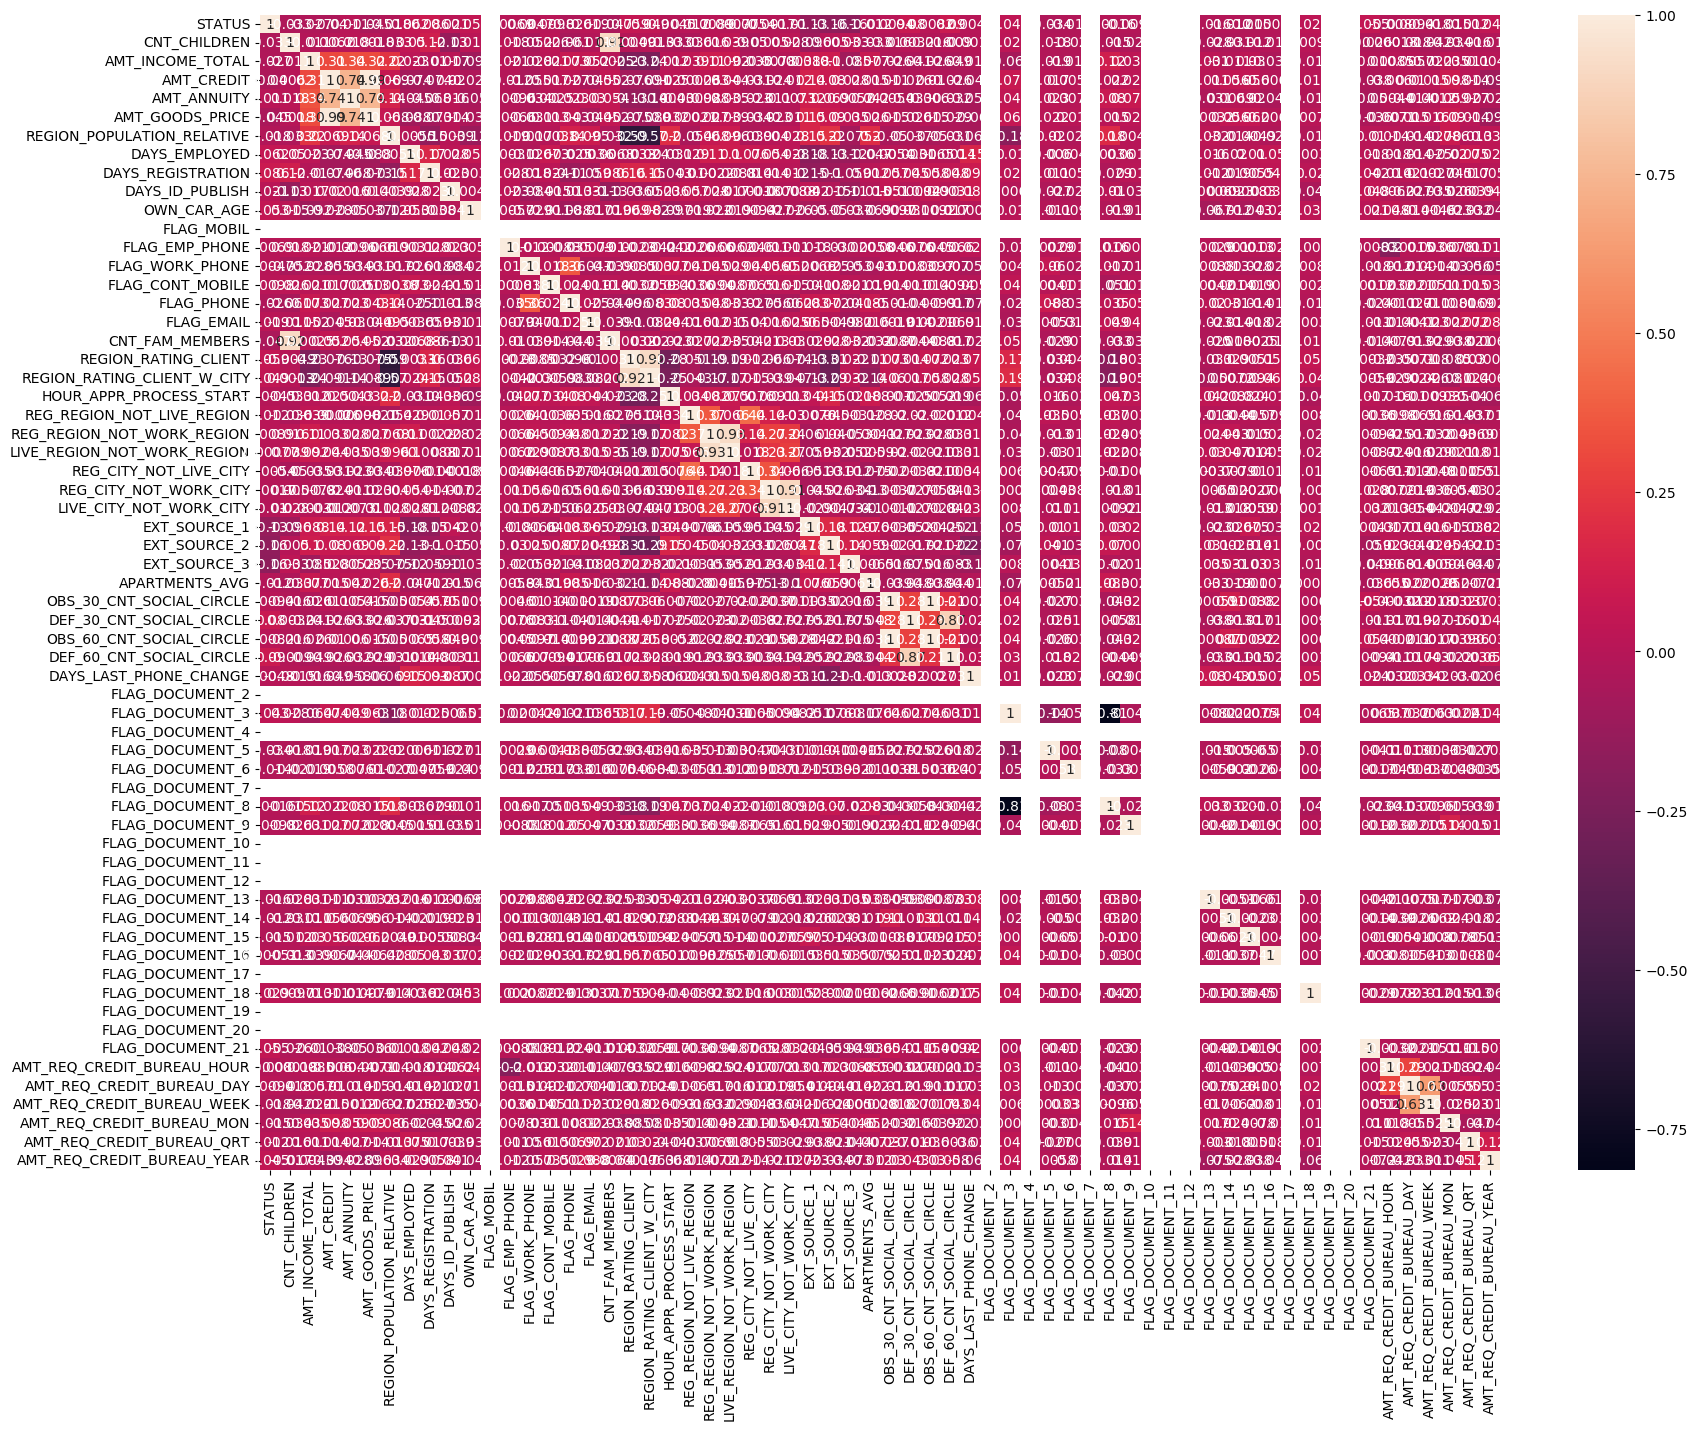

In [17]:
# 62 continous variables
continuous_df = df_filtered_forsc[cont_var_list]
corr_df = continuous_df.corr()

plt.subplots(figsize=(20,15))
sns.heatmap(corr_df, annot=True)
# 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'

In [18]:
cat_var_df # only 1 missing categorical var (name_type_suite)

,variable,dtype,count,unique,missing,pc_missing
1,NAME_CONTRACT_TYPE,object,18603,2,0,0.00
2,FLAG_OWN_CAR,object,18603,2,0,0.00
3,FLAG_OWN_REALTY,object,18603,2,0,0.00
9,NAME_TYPE_SUITE,object,18603,8,82,0.44
10,NAME_INCOME_TYPE,object,18603,4,0,0.00
11,NAME_EDUCATION_TYPE,object,18603,5,0,0.00
12,NAME_FAMILY_STATUS,object,18603,5,0,0.00
13,NAME_HOUSING_TYPE,object,18603,6,0,0.00
25,OCCUPATION_TYPE,object,18603,1,0,0.00
29,WEEKDAY_APPR_PROCESS_START,object,18603,7,0,0.00


In [19]:
# cont_var_df[cont_var_df['missing'] > 0].count() ==> 17 missing continous var
cont_var_df[cont_var_df['missing'] > 0]

,variable,dtype,count,unique,missing,pc_missing
7,AMT_ANNUITY,float64,18603,5642,1,0.01
8,AMT_GOODS_PRICE,float64,18603,396,13,0.07
18,OWN_CAR_AGE,float64,18603,53,5803,31.19
38,EXT_SOURCE_1,float64,18603,6768,11768,63.26
39,EXT_SOURCE_2,float64,18603,16945,28,0.15
40,EXT_SOURCE_3,float64,18603,688,3944,21.20
41,APARTMENTS_AVG,float64,18603,946,10475,56.31
42,OBS_30_CNT_SOCIAL_CIRCLE,float64,18603,25,36,0.19
43,DEF_30_CNT_SOCIAL_CIRCLE,float64,18603,7,36,0.19
44,OBS_60_CNT_SOCIAL_CIRCLE,float64,18603,25,36,0.19


In [20]:
# cont_var_df[cont_var_df['pc_missing'] > 5].count() 
# # ==> 10 continous variables with more than 5 pc_change

cont_var_df[cont_var_df['pc_missing'] > 5]

,variable,dtype,count,unique,missing,pc_missing
18,OWN_CAR_AGE,float64,18603,53,5803,31.19
38,EXT_SOURCE_1,float64,18603,6768,11768,63.26
40,EXT_SOURCE_3,float64,18603,688,3944,21.20
41,APARTMENTS_AVG,float64,18603,946,10475,56.31
67,AMT_REQ_CREDIT_BUREAU_HOUR,float64,18603,5,2628,14.13
68,AMT_REQ_CREDIT_BUREAU_DAY,float64,18603,8,2628,14.13
69,AMT_REQ_CREDIT_BUREAU_WEEK,float64,18603,8,2628,14.13
70,AMT_REQ_CREDIT_BUREAU_MON,float64,18603,20,2628,14.13
71,AMT_REQ_CREDIT_BUREAU_QRT,float64,18603,7,2628,14.13
72,AMT_REQ_CREDIT_BUREAU_YEAR,float64,18603,16,2628,14.13


In [21]:
# cont_var_df[cont_var_df['pc_missing'] > 5].count() 
# # ==> 10 continous variables with more than 5 pc_change

more_than_5pc_cont_var_df = cont_var_df[cont_var_df['pc_missing'] > 5]

In [22]:
more_than_5pc_cont_var_list = list(more_than_5pc_cont_var_df['variable'])

In [23]:
more_than_5pc_cont_var_list
# len(more_than_5pc_cont_var_list) => 10

['OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [24]:
df_filtered_forsc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1711 entries, 218 to 307040
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   STATUS                       1711 non-null   int64  
 1   NAME_CONTRACT_TYPE           1711 non-null   object 
 2   FLAG_OWN_CAR                 1711 non-null   object 
 3   FLAG_OWN_REALTY              1711 non-null   object 
 4   CNT_CHILDREN                 1711 non-null   int64  
 5   AMT_INCOME_TOTAL             1711 non-null   float64
 6   AMT_CREDIT                   1711 non-null   float64
 7   AMT_ANNUITY                  1711 non-null   float64
 8   AMT_GOODS_PRICE              1711 non-null   float64
 9   NAME_TYPE_SUITE              1711 non-null   object 
 10  NAME_INCOME_TYPE             1711 non-null   object 
 11  NAME_EDUCATION_TYPE          1711 non-null   object 
 12  NAME_FAMILY_STATUS           1711 non-null   object 
 13  NAME_HOUSING_T

In [25]:
# after
df_filtered_forsc.drop(columns = more_than_5pc_cont_var_list, inplace=True)

In [26]:
# df_filtered_forsc.info()

In [27]:
new_columns_infoDF = show_missing(df_filtered_forsc)

In [28]:
# new_columns_infoDF.info() # ==>  63 columns 
new_cont_col = new_columns_infoDF[new_columns_infoDF['dtype'] != 'object']
new_cont_col.info() #52 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 62
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   variable    52 non-null     object 
 1   dtype       52 non-null     object 
 2   count       52 non-null     int64  
 3   unique      52 non-null     int64  
 4   missing     52 non-null     int64  
 5   pc_missing  52 non-null     float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ KB


In [29]:
new_cont_col_list = list(new_cont_col['variable'])
len(new_cont_col_list)

52

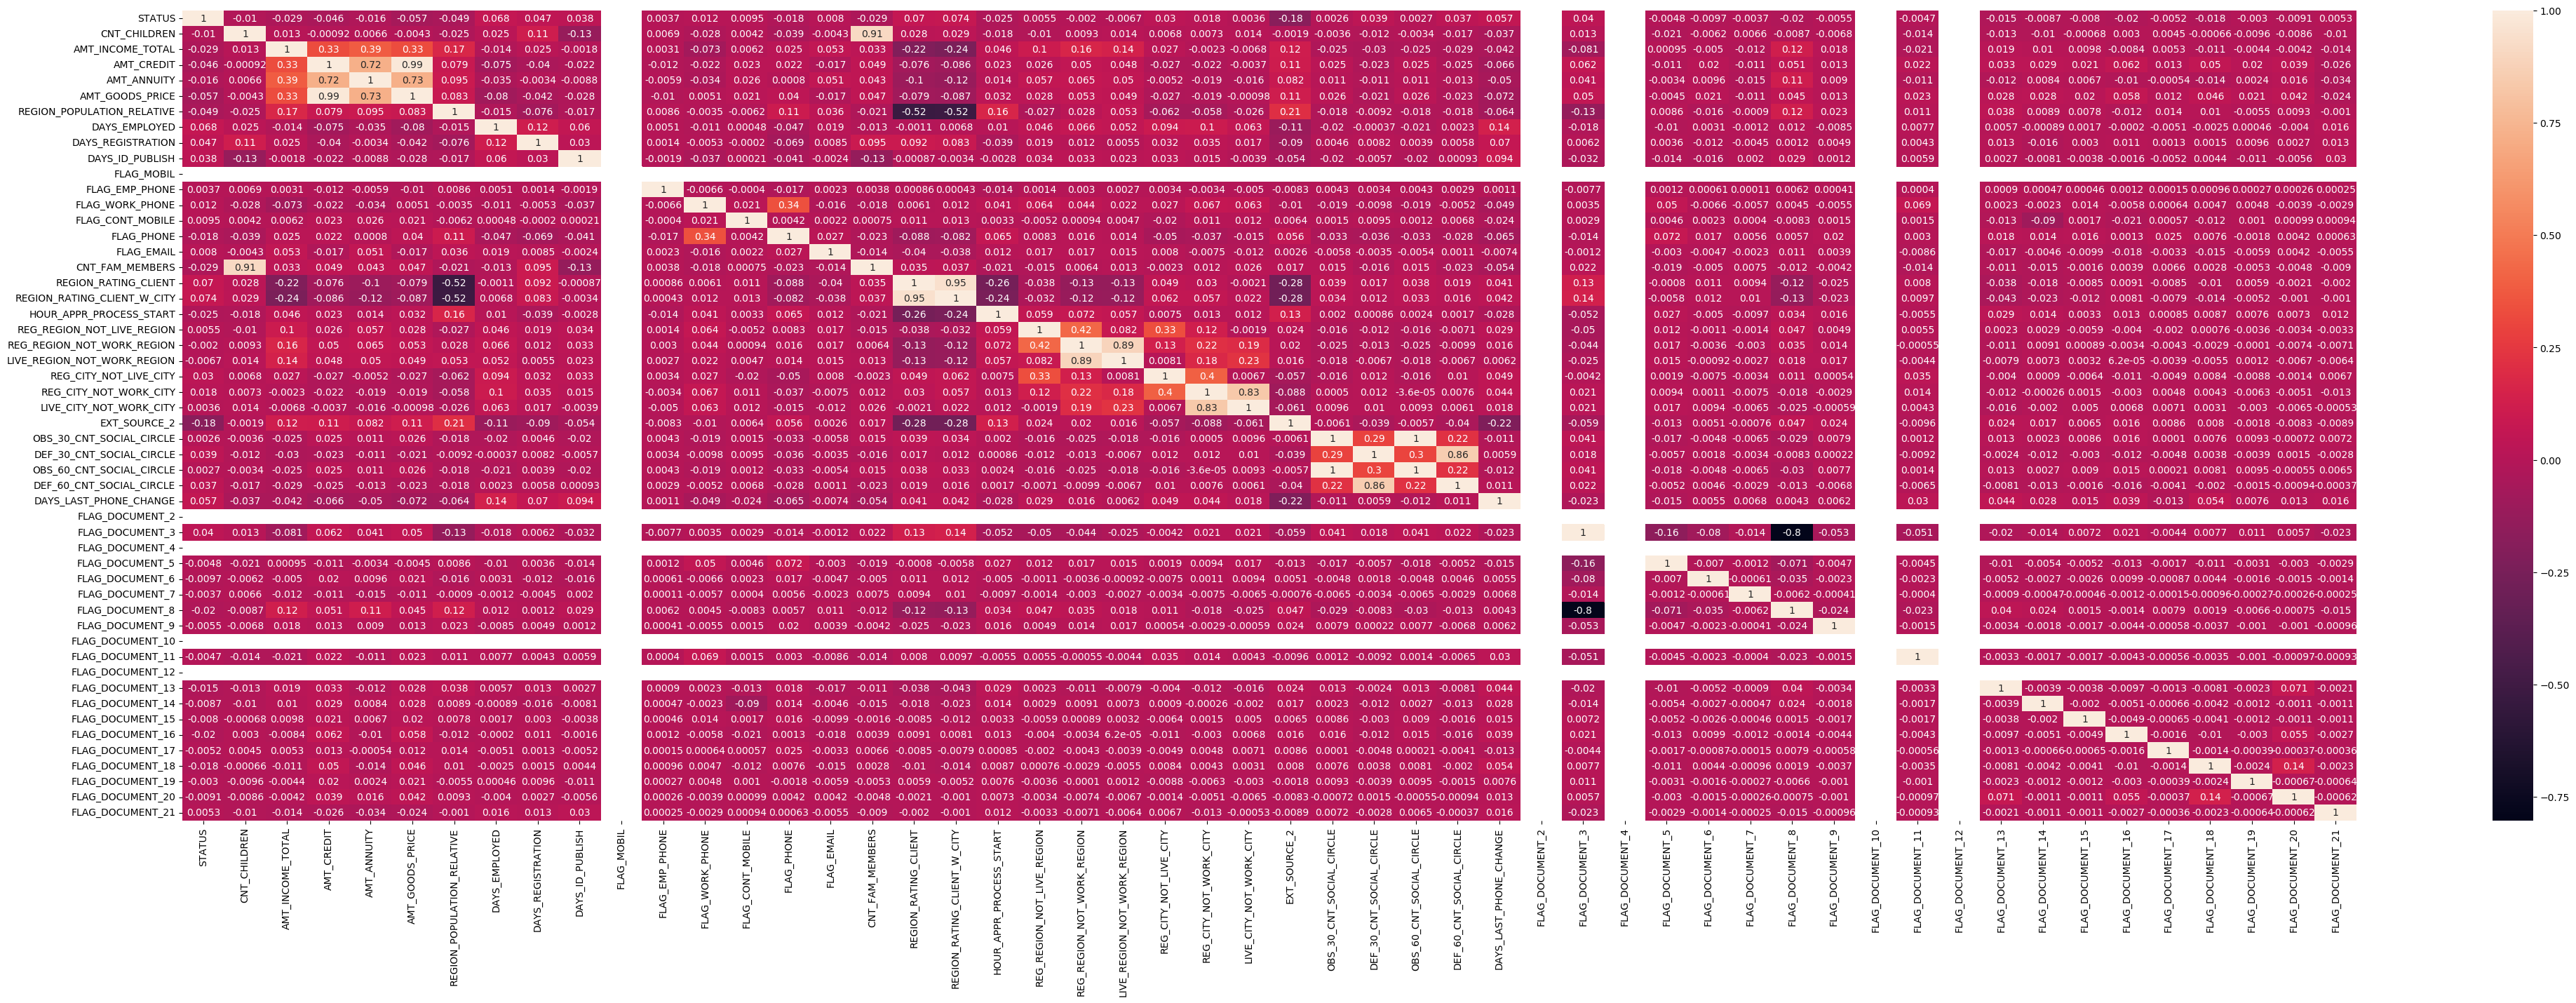

In [30]:
continuous_df = df_filtered[new_cont_col_list]
corr_df = continuous_df.corr()

plt.subplots(figsize=(50,15))
sns.heatmap(corr_df, annot=True)
# 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'

In [31]:
# new_cont_col_list

In [32]:
invalid_corr_cont_col_list = ['FLAG_MOBIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12']
highly_corr_cont_col_list = ['CNT_FAM_MEMBERS','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']
#amt_credit still here

In [33]:
drop_col_list = invalid_corr_cont_col_list + highly_corr_cont_col_list
len(drop_col_list)

15

In [34]:
invalid_highly_corr_cont_col_list = ['FLAG_MOBIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12','CNT_FAM_MEMBERS','AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']
len(invalid_highly_corr_cont_col_list)

14

Drop MORTDUE, is highly correlated with VALUE


In [35]:
# only remove code_gender, day_birth, 10 of 5pc missing values => 75-12 = 63
df_filtered_forsc

,STATUS,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
218,0,Cash loans,Y,Y,0,292500.0,1078200.0,34911.0,900000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.046220,-2127,-381.0,-4264,1,1,0,1,1,0,Drivers,2.0,1,1,FRIDAY,15,0,0,0,0,0,0,Business Entity Type 3,0.750443,2.0,1.0,2.0,1.0,-307.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
236,0,Cash loans,Y,Y,0,308250.0,1305000.0,38281.5,1305000.0,Family,Working,Secondary / secondary special,Civil marriage,House / apartment,0.026392,-1106,-8060.0,-4018,1,1,1,1,1,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Self-employed,0.698453,1.0,0.0,1.0,0.0,-2263.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
298,0,Cash loans,Y,Y,0,315000.0,90000.0,4504.5,90000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,With parents,0.022800,-422,-5251.0,-3364,1,1,0,1,1,0,Drivers,1.0,2,2,SATURDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.581980,2.0,0.0,2.0,0.0,-1016.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
328,0,Cash loans,Y,Y,0,360000.0,254700.0,20250.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018801,-1342,-8691.0,-2067,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,10,0,0,0,0,0,0,Transport: type 3,0.445987,0.0,0.0,0.0,0.0,-542.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
335,0,Cash loans,Y,Y,2,292500.0,1095817.5,43587.0,1008000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.003069,-1559,-395.0,-4249,1,1,0,1,0,0,Drivers,4.0,3,3,FRIDAY,14,0,0,0,0,0,0,Industry: type 3,0.514818,0.0,0.0,0.0,0.0,-757.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305453,0,Cash loans,Y,Y,0,301500.0,1288350.0,37800.0,1125000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.006305,-2023,-4294.0,-612,1,1,0,1,0,0,Drivers,2.0,3,3,MONDAY,4,0,0,0,0,0,0,Self-employed,0.390868,3.0,2.0,3.0,1.0,-647.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
305644,0,Cash loans,Y,Y,2,103500.0,302206.5,15561.0,229500.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.006008,-1597,-6776.0,-4368,1,1,0,1,0,0,Drivers,4.0,2,2,THURSDAY,15,0,0,0,0,0,0,Industry: type 1,0.695617,4.0,2.0,4.0,0.0,-822.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
305649,0,Cash loans,Y,N,2,202500.0,854901.0,33399.0,738000.0,"Spouse, partner",Working,Secondary / secondary special,Married,With parents,0.014464,-1538,-2516.0,-1015,1,1,0,1,1,0,Drivers,4.0,2,2,MONDAY,9,0,0,0,0,1,1,Business Entity Type 3,0.704128,0.0,0.0,0.0,0.0,-916.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
306911,0,Cash loans,Y,Y,0,247500.0,594261.0,51133.5,526500.0,Unaccompanied,Working,Secondary / secondary special,Single / not marrie

In [36]:
# sample code
# drop_col = ['MORTDUE', 'JOB', 'REASON', 'LOAN']

drop_col = invalid_highly_corr_cont_col_list 
df_filtered_forsc.drop(columns= drop_col, inplace= True)

In [37]:
df_filtered_forsc # 1711 rows x 49 columns 

,STATUS,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
218,0,Cash loans,Y,Y,0,292500.0,1078200.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.046220,-2127,-381.0,-4264,1,0,1,1,0,Drivers,FRIDAY,15,0,0,0,0,Business Entity Type 3,0.750443,2.0,2.0,-307.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
236,0,Cash loans,Y,Y,0,308250.0,1305000.0,Family,Working,Secondary / secondary special,Civil marriage,House / apartment,0.026392,-1106,-8060.0,-4018,1,1,1,1,0,Drivers,MONDAY,14,0,0,0,0,Self-employed,0.698453,1.0,1.0,-2263.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
298,0,Cash loans,Y,Y,0,315000.0,90000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,With parents,0.022800,-422,-5251.0,-3364,1,0,1,1,0,Drivers,SATURDAY,11,0,0,0,0,Business Entity Type 3,0.581980,2.0,2.0,-1016.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
328,0,Cash loans,Y,Y,0,360000.0,254700.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018801,-1342,-8691.0,-2067,1,0,1,0,0,Drivers,MONDAY,10,0,0,0,0,Transport: type 3,0.445987,0.0,0.0,-542.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
335,0,Cash loans,Y,Y,2,292500.0,1095817.5,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.003069,-1559,-395.0,-4249,1,0,1,0,0,Drivers,FRIDAY,14,0,0,0,0,Industry: type 3,0.514818,0.0,0.0,-757.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305453,0,Cash loans,Y,Y,0,301500.0,1288350.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.006305,-2023,-4294.0,-612,1,0,1,0,0,Drivers,MONDAY,4,0,0,0,0,Self-employed,0.390868,3.0,3.0,-647.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
305644,0,Cash loans,Y,Y,2,103500.0,302206.5,Family,Working,Secondary / secondary special,Married,House / apartment,0.006008,-1597,-6776.0,-4368,1,0,1,0,0,Drivers,THURSDAY,15,0,0,0,0,Industry: type 1,0.695617,4.0,4.0,-822.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
305649,0,Cash loans,Y,N,2,202500.0,854901.0,"Spouse, partner",Working,Secondary / secondary special,Married,With parents,0.014464,-1538,-2516.0,-1015,1,0,1,1,0,Drivers,MONDAY,9,0,0,0,0,Business Entity Type 3,0.704128,0.0,0.0,-916.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
306911,0,Cash loans,Y,Y,0,247500.0,594261.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-480,-5397.0,-3922,1,0,1,0,1,Drivers,THURSDAY,6,0,0,0,0,Transport: type 3,0.357880,0.0,0.0,-469.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [38]:
df_filtered_forsc['STATUS'].value_counts()

0    1582
1     129
Name: STATUS, dtype: int64

In [39]:
df_filtered_forsc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1711 entries, 218 to 307040
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   STATUS                       1711 non-null   int64  
 1   NAME_CONTRACT_TYPE           1711 non-null   object 
 2   FLAG_OWN_CAR                 1711 non-null   object 
 3   FLAG_OWN_REALTY              1711 non-null   object 
 4   CNT_CHILDREN                 1711 non-null   int64  
 5   AMT_INCOME_TOTAL             1711 non-null   float64
 6   AMT_CREDIT                   1711 non-null   float64
 7   NAME_TYPE_SUITE              1711 non-null   object 
 8   NAME_INCOME_TYPE             1711 non-null   object 
 9   NAME_EDUCATION_TYPE          1711 non-null   object 
 10  NAME_FAMILY_STATUS           1711 non-null   object 
 11  NAME_HOUSING_TYPE            1711 non-null   object 
 12  REGION_POPULATION_RELATIVE   1711 non-null   float64
 13  DAYS_EMPLOYED 

**Generate WOE bins**

Woebin() generate groupings as a python dictionary object and also provides a method to plot WOE for the bins.  It will optimize for IV, but will not attempt to make the trend monotonic.

In [40]:
# automatically calculate bin ranges 
bins = sc.woebin(df_filtered_forsc, 'STATUS')

# make it easy to read the bins
for variables , bindetails in bins.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)
    
# look at less that -0.1 as bad predictive

[INFO] creating woe binning ...
NAME_HOUSING_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_HOUSING_TYPE,"Office apartment%,%House / apartment%,%Municip...",1561,0.912332,1451,110,0.070468,-0.072895,0.004700,0.041833,"Office apartment%,%House / apartment%,%Municip...",False
1,NAME_HOUSING_TYPE,"With parents%,%Rented apartment%,%Co-op apartment",150,0.087668,131,19,0.126667,0.575874,0.037133,0.041833,"With parents%,%Rented apartment%,%Co-op apartment",False


----------------------------------------------------------------------------------------------------
DAYS_EMPLOYED  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_EMPLOYED,"[-inf,-3800.0)",224,0.130918,217,7,0.031250,-0.927354,0.076882,0.200266,-3800.0,False
1,DAYS_EMPLOYED,"[-3800.0,-2800.0)",181,0.105786,165,16,0.088398,0.173276,0.003419,0.200266,-2800.0,False
2,DAYS_EMPLOYED,"[-2800.0,-2200.0)",147,0.085915,143,4,0.027211,-1.069918,0.063536,0.200266,-2200.0,False
3,DAYS_EMPLOYED,"[-2200.0,-1600.0)",202,0.118060,190,12,0.059406,-0.255485,0.006918,0.200266,-1600.0,False
4,DAYS_EMPLOYED,"[-1600.0,-1200.0)",182,0.106371,160,22,0.120879,0.522501,0.036264,0.200266,-1200.0,False
5,DAYS_EMPLOYED,"[-1200.0,inf)",775,0.452951,707,68,0.087742,0.165110,0.013247,0.200266,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_5  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_5,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
NAME_FAMILY_STATUS  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_FAMILY_STATUS,Married,1257,0.734658,1175,82,0.065235,-0.155671,0.016668,0.054815,Married,False
1,NAME_FAMILY_STATUS,Single / not married,204,0.119229,184,20,0.098039,0.287429,0.011132,0.054815,Single / not married,False
2,NAME_FAMILY_STATUS,"Civil marriage%,%Widow%,%Separated",250,0.146113,223,27,0.108000,0.395298,0.027015,0.054815,"Civil marriage%,%Widow%,%Separated",False


----------------------------------------------------------------------------------------------------
DAYS_LAST_PHONE_CHANGE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_LAST_PHONE_CHANGE,"[-inf,-2400.0)",166,0.097019,157,9,0.054217,-0.352388,0.010386,0.081469,-2400.0,False
1,DAYS_LAST_PHONE_CHANGE,"[-2400.0,-1800.0)",210,0.122735,188,22,0.104762,0.361233,0.018678,0.081469,-1800.0,False
2,DAYS_LAST_PHONE_CHANGE,"[-1800.0,-1500.0)",206,0.120397,189,17,0.082524,0.098099,0.001208,0.081469,-1500.0,False
3,DAYS_LAST_PHONE_CHANGE,"[-1500.0,-800.0)",366,0.213910,345,21,0.057377,-0.292389,0.016166,0.081469,-800.0,False
4,DAYS_LAST_PHONE_CHANGE,"[-800.0,-600.0)",139,0.081239,129,10,0.071942,-0.050595,0.000204,0.081469,-600.0,False
5,DAYS_LAST_PHONE_CHANGE,"[-600.0,-500.0)",94,0.054939,84,10,0.106383,0.378401,0.009241,0.081469,-500.0,False
6,DAYS_LAST_PHONE_CHANGE,"[-500.0,-300.0)",136,0.079486,130,6,0.044118,-0.569142,0.020297,0.081469,-300.0,False
7,DAYS_LAST_PHONE_CHANGE,"[-300.0,inf)",394,0.230275,360,34,0.086294,0.146889,0.005289,0.081469,inf,False


----------------------------------------------------------------------------------------------------
REG_CITY_NOT_LIVE_CITY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_CITY_NOT_LIVE_CITY,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
EXT_SOURCE_2  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_2,"[-inf,0.30000000000000004)",190,0.111046,153,37,0.194737,1.087113,0.206670,0.326924,0.30000000000000004,False
1,EXT_SOURCE_2,"[0.30000000000000004,0.4)",125,0.073057,111,14,0.112000,0.436160,0.016732,0.326924,0.4,False
2,EXT_SOURCE_2,"[0.4,0.7000000000000001)",1034,0.604325,970,64,0.061896,-0.211780,0.024783,0.326924,0.7000000000000001,False
3,EXT_SOURCE_2,"[0.7000000000000001,inf)",362,0.211572,348,14,0.038674,-0.706512,0.078739,0.326924,inf,False


----------------------------------------------------------------------------------------------------
AMT_INCOME_TOTAL  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_INCOME_TOTAL,"[-inf,150000.0)",420,0.245470,387,33,0.078571,0.044716,0.000500,0.061717,150000.0,False
1,AMT_INCOME_TOTAL,"[150000.0,180000.0)",214,0.125073,193,21,0.098131,0.288465,0.011767,0.061717,180000.0,False
2,AMT_INCOME_TOTAL,"[180000.0,190000.0)",213,0.124489,202,11,0.051643,-0.403740,0.017125,0.061717,190000.0,False
3,AMT_INCOME_TOTAL,"[190000.0,270000.0)",482,0.281707,439,43,0.089212,0.183333,0.010237,0.061717,270000.0,False
4,AMT_INCOME_TOTAL,"[270000.0,inf)",382,0.223261,361,21,0.054974,-0.337723,0.022088,0.061717,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_15  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_15,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
LIVE_REGION_NOT_WORK_REGION  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVE_REGION_NOT_WORK_REGION,"[-inf,1.0)",1606,0.938632,1485,121,0.075342,-0.000747,5.232652e-07,0.000008,1.0,False
1,LIVE_REGION_NOT_WORK_REGION,"[1.0,inf)",105,0.061368,97,8,0.076190,0.011363,7.962411e-06,0.000008,inf,False


----------------------------------------------------------------------------------------------------
NAME_TYPE_SUITE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_TYPE_SUITE,"Children%,%Other_A%,%Family",211,0.12332,197,14,0.066351,-0.137514,0.00220,0.00249,"Children%,%Other_A%,%Family",False
1,NAME_TYPE_SUITE,"Unaccompanied%,%Spouse, partner%,%Other_B",1500,0.87668,1385,115,0.076667,0.018109,0.00029,0.00249,"Unaccompanied%,%Spouse, partner%,%Other_B",False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_13  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_13,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_EMAIL  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_EMAIL,"[-inf,1.0)",1546,0.903565,1432,114,0.073739,-0.023996,0.000515,0.004894,1.0,False
1,FLAG_EMAIL,"[1.0,inf)",165,0.096435,150,15,0.090909,0.204048,0.004379,0.004894,inf,False


----------------------------------------------------------------------------------------------------
WEEKDAY_APPR_PROCESS_START  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,WEEKDAY_APPR_PROCESS_START,"SATURDAY%,%SUNDAY",286,0.167154,275,11,0.038462,-0.712243,0.063076,0.090882,"SATURDAY%,%SUNDAY",False
1,WEEKDAY_APPR_PROCESS_START,"THURSDAY%,%TUESDAY%,%WEDNESDAY",862,0.503799,798,64,0.074246,-0.016593,0.000138,0.090882,"THURSDAY%,%TUESDAY%,%WEDNESDAY",False
2,WEEKDAY_APPR_PROCESS_START,MONDAY,301,0.175921,274,27,0.089701,0.189342,0.006836,0.090882,MONDAY,False
3,WEEKDAY_APPR_PROCESS_START,FRIDAY,262,0.153127,235,27,0.103053,0.342884,0.020832,0.090882,FRIDAY,False


----------------------------------------------------------------------------------------------------
OBS_60_CNT_SOCIAL_CIRCLE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OBS_60_CNT_SOCIAL_CIRCLE,"[-inf,1.0)",886,0.517826,826,60,0.067720,-0.115617,0.006591,0.050688,1.0,False
1,OBS_60_CNT_SOCIAL_CIRCLE,"[1.0,2.0)",312,0.182350,282,30,0.096154,0.265923,0.014440,0.050688,2.0,False
2,OBS_60_CNT_SOCIAL_CIRCLE,"[2.0,4.0)",268,0.156634,245,23,0.085821,0.140869,0.003300,0.050688,4.0,False
3,OBS_60_CNT_SOCIAL_CIRCLE,"[4.0,6.0)",139,0.081239,133,6,0.043165,-0.591957,0.022233,0.050688,6.0,False
4,OBS_60_CNT_SOCIAL_CIRCLE,"[6.0,inf)",106,0.061952,96,10,0.094340,0.244870,0.004123,0.050688,inf,False


----------------------------------------------------------------------------------------------------
FLAG_PHONE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_PHONE,"[-inf,1.0)",1161,0.678551,1068,93,0.080103,0.065689,0.003011,0.009981,1.0,False
1,FLAG_PHONE,"[1.0,inf)",550,0.321449,514,36,0.065455,-0.152072,0.006970,0.009981,inf,False


----------------------------------------------------------------------------------------------------
NAME_CONTRACT_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_CONTRACT_TYPE,Revolving loans,128,0.07481,125,3,0.023438,-1.223069,0.068196,0.071473,Revolving loans,False
1,NAME_CONTRACT_TYPE,Cash loans,1583,0.92519,1457,126,0.079596,0.058780,0.003277,0.071473,Cash loans,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_8  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_8,"[-inf,1.0)",1176,0.687317,1087,89,0.075680,0.004092,0.000012,0.000037,1.0,False
1,FLAG_DOCUMENT_8,"[1.0,inf)",535,0.312683,495,40,0.074766,-0.009046,0.000025,0.000037,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_9  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_9,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
AMT_CREDIT  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,350000.0)",538,0.314436,503,35,0.065056,-0.158609,0.007397,0.202578,350000.0,False
1,AMT_CREDIT,"[350000.0,550000.0)",338,0.197545,298,40,0.118343,0.498419,0.060662,0.202578,550000.0,False
2,AMT_CREDIT,"[550000.0,750000.0)",266,0.155465,240,26,0.097744,0.284090,0.014160,0.202578,750000.0,False
3,AMT_CREDIT,"[750000.0,950000.0)",227,0.132671,212,15,0.066079,-0.141903,0.002516,0.202578,950000.0,False
4,AMT_CREDIT,"[950000.0,1200000.0)",157,0.091759,154,3,0.019108,-1.431708,0.106074,0.202578,1200000.0,False
5,AMT_CREDIT,"[1200000.0,inf)",185,0.108124,175,10,0.054054,-0.355568,0.011769,0.202578,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_18  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_18,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
OBS_30_CNT_SOCIAL_CIRCLE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OBS_30_CNT_SOCIAL_CIRCLE,"[-inf,1.0)",884,0.516657,825,59,0.066742,-0.131213,0.008414,0.061044,1.0,False
1,OBS_30_CNT_SOCIAL_CIRCLE,"[1.0,2.0)",308,0.180012,277,31,0.100649,0.316602,0.020647,0.061044,2.0,False
2,OBS_30_CNT_SOCIAL_CIRCLE,"[2.0,4.0)",270,0.157802,247,23,0.085185,0.132739,0.002942,0.061044,4.0,False
3,OBS_30_CNT_SOCIAL_CIRCLE,"[4.0,6.0)",143,0.083577,137,6,0.041958,-0.621589,0.024918,0.061044,6.0,False
4,OBS_30_CNT_SOCIAL_CIRCLE,"[6.0,inf)",106,0.061952,96,10,0.094340,0.244870,0.004123,0.061044,inf,False


----------------------------------------------------------------------------------------------------
CNT_CHILDREN  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CNT_CHILDREN,"[-inf,1.0)",998,0.583285,917,81,0.081162,0.079974,0.003860,0.021953,1.0,False
1,CNT_CHILDREN,"[1.0,2.0)",466,0.272355,431,35,0.075107,-0.004127,0.000005,0.021953,2.0,False
2,CNT_CHILDREN,"[2.0,inf)",247,0.144360,234,13,0.052632,-0.383739,0.018089,0.021953,inf,False


----------------------------------------------------------------------------------------------------
NAME_EDUCATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_EDUCATION_TYPE,"Lower secondary%,%Higher education",282,0.164816,271,11,0.039007,-0.697591,0.060014,0.068512,"Lower secondary%,%Higher education",False
1,NAME_EDUCATION_TYPE,"Secondary / secondary special%,%Incomplete higher",1429,0.835184,1311,118,0.082575,0.098772,0.008497,0.068512,"Secondary / secondary special%,%Incomplete higher",False


----------------------------------------------------------------------------------------------------
FLAG_EMP_PHONE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_EMP_PHONE,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_CONT_MOBILE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_CONT_MOBILE,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
DAYS_ID_PUBLISH  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_ID_PUBLISH,"[-inf,-4400.0)",385,0.225015,356,29,0.075325,-0.001002,2.258902e-07,0.134994,-4400.0,False
1,DAYS_ID_PUBLISH,"[-4400.0,-4200.0)",150,0.087668,144,6,0.040000,-0.671421,2.988656e-02,0.134994,-4200.0,False
2,DAYS_ID_PUBLISH,"[-4200.0,-3500.0)",306,0.178843,287,19,0.062092,-0.208410,7.112864e-03,0.134994,-3500.0,False
3,DAYS_ID_PUBLISH,"[-3500.0,-2700.0)",242,0.141438,214,28,0.115702,0.472861,3.867175e-02,0.134994,-2700.0,False
4,DAYS_ID_PUBLISH,"[-2700.0,-2200.0)",124,0.072472,120,4,0.032258,-0.894565,4.011729e-02,0.134994,-2200.0,False
5,DAYS_ID_PUBLISH,"[-2200.0,-400.0)",397,0.232028,360,37,0.093199,0.231447,1.371591e-02,0.134994,-400.0,False
6,DAYS_ID_PUBLISH,"[-400.0,inf)",107,0.062537,101,6,0.056075,-0.316728,5.489411e-03,0.134994,inf,False


----------------------------------------------------------------------------------------------------
ORGANIZATION_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ORGANIZATION_TYPE,"Advertising%,%Transport: type 1%,%Trade: type ...",266,0.155465,265,1,0.003759,-3.073097,0.490950,0.641541,"Advertising%,%Transport: type 1%,%Trade: type ...",False
1,ORGANIZATION_TYPE,"Government%,%Trade: type 7%,%Industry: type 3%...",173,0.101110,167,6,0.034682,-0.819602,0.048398,0.641541,"Government%,%Trade: type 7%,%Industry: type 3%...",False
2,ORGANIZATION_TYPE,"Military%,%Business Entity Type 3%,%Business E...",643,0.375804,594,49,0.076205,0.011574,0.000051,0.641541,"Military%,%Business Entity Type 3%,%Business E...",False
3,ORGANIZATION_TYPE,"Self-employed%,%Transport: type 4%,%Medicine%,...",629,0.367621,556,73,0.116057,0.476324,0.102142,0.641541,"Self-employed%,%Transport: type 4%,%Medicine%,...",False


----------------------------------------------------------------------------------------------------
DAYS_REGISTRATION  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_REGISTRATION,"[-inf,-6500.0)",489,0.285798,469,20,0.040900,-0.648238,0.091675,0.147837,-6500.0,False
1,DAYS_REGISTRATION,"[-6500.0,-5500.0)",162,0.094681,152,10,0.061728,-0.214663,0.003984,0.147837,-5500.0,False
2,DAYS_REGISTRATION,"[-5500.0,-500.0)",899,0.525424,820,79,0.087875,0.166776,0.015689,0.147837,-500.0,False
3,DAYS_REGISTRATION,"[-500.0,inf)",161,0.094097,141,20,0.124224,0.553605,0.036489,0.147837,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_21  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_21,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_WORK_PHONE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_WORK_PHONE,"[-inf,1.0)",1351,0.789597,1250,101,0.074759,-0.009146,0.000066,0.000308,1.0,False
1,FLAG_WORK_PHONE,"[1.0,inf)",360,0.210403,332,28,0.077778,0.033702,0.000242,0.000308,inf,False


----------------------------------------------------------------------------------------------------
REG_REGION_NOT_LIVE_REGION  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_REGION_NOT_LIVE_REGION,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_14  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_14,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_OWN_REALTY  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_OWN_REALTY,N,610,0.356517,565,45,0.073770,-0.023530,0.000195,0.000302,N,False
1,FLAG_OWN_REALTY,Y,1101,0.643483,1017,84,0.076294,0.012837,0.000107,0.000302,Y,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_6  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_6,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_16  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_16,"[-inf,inf)",1711,1.0,1582,129,0.075395,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
NAME_INCOME_TYPE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,"Student%,%State servant",94,0.054939,90,4,0.042553,-0.606883,0.015707,0.03484,"Student%,%State servant",False
1,NAME_INCOME_TYPE,Commercial associate,480,0.280538,450,30,0.062500,-0.201417,0.010452,0.03484,Commercial associate,False
2,NAME_INCOME_TYPE,Working,1137,0.664524,1042,95,0.083553,0.111612,0.008681,0.03484,Working,False


----------------------------------------------------------------------------------------------------
FLAG_DOCUMENT_3  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_3,"[-inf,1.0)",696,0.40678,653,43,0.061782,-0.213744,0.016979,0.027057,1.0,False
1,FLAG_DOCUMENT_3,"[1.0,inf)",1015,0.59322,929,86,0.084729,0.126871,0.010078,0.027057,inf,False


----------------------------------------------------------------------------------------------------
REGION_POPULATION_RELATIVE  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_POPULATION_RELATIVE,"[-inf,0.01)",340,0.198714,322,18,0.052941,-0.377547,0.024165,0.090261,0.01,False
1,REGION_POPULATION_RELATIVE,"[0.01,0.02)",548,0.320281,503,45,0.082117,0.092705,0.002863,0.090261,0.02,False
2,REGION_POPULATION_RELATIVE,"[0.02,0.03)",378,0.220923,338,40,0.105820,0.372466,0.035915,0.090261,0.03,False
3,REGION_POPULATION_RELATIVE,"[0.03,0.04)",228,0.133255,213,15,0.065789,-0.146609,0.002692,0.090261,0.04,False
4,REGION_POPULATION_RELATIVE,"[0.04,0.05)",115,0.067212,108,7,0.060870,-0.229588,0.003215,0.090261,0.05,False
5,REGION_POPULATION_RELATIVE,"[0.05,inf)",102,0.059614,98,4,0.039216,-0.692040,0.021411,0.090261,inf,False


----------------------------------------------------------------------------------------------------
HOUR_APPR_PROCESS_START  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,HOUR_APPR_PROCESS_START,"[-inf,10.0)",313,0.182934,292,21,0.067093,-0.125599,0.002736,0.066806,10.0,False
1,HOUR_APPR_PROCESS_START,"[10.0,17.0)",1204,0.703682,1107,97,0.080565,0.071935,0.003754,0.066806,17.0,False
2,HOUR_APPR_PROCESS_START,"[17.0,18.0)",95,0.055523,93,2,0.021053,-1.332820,0.057688,0.066806,18.0,False
3,HOUR_APPR_PROCESS_START,"[18.0,inf)",99,0.057861,90,9,0.090909,0.204048,0.002628,0.066806,inf,False


----------------------------------------------------------------------------------------------------
REG_REGION_NOT_WORK_REGION  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_REGION_NOT_WORK_REGION,"[-inf,1.0)",1592,0.93045,1473,119,0.074749,-0.00930,0.000080,0.001096,1.0,False
1,REG_REGION_NOT_WORK_REGION,"[1.0,inf)",119,0.06955,109,10,0.084034,0.11787,0.001016,0.001096,inf,False


----------------------------------------------------------------------------------------------------


In [54]:
df_filtered_forsc['FLAG_DOCUMENT_19'].value_counts()


0    1711
Name: FLAG_DOCUMENT_19, dtype: int64

In [52]:
df_filtered_forsc['FLAG_OWN_CAR'].value_counts()

Y    1711
Name: FLAG_OWN_CAR, dtype: int64

In [53]:
df_filtered_forsc['NAME_HOUSING_TYPE'].value_counts()

House / apartment      1473
With parents            114
Municipal apartment      74
Rented apartment         31
Office apartment         14
Co-op apartment           5
Name: NAME_HOUSING_TYPE, dtype: int64

In [47]:
df_filtered_forsc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1711 entries, 218 to 307040
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   STATUS                       1711 non-null   int64  
 1   NAME_CONTRACT_TYPE           1711 non-null   object 
 2   FLAG_OWN_CAR                 1711 non-null   object 
 3   FLAG_OWN_REALTY              1711 non-null   object 
 4   CNT_CHILDREN                 1711 non-null   int64  
 5   AMT_INCOME_TOTAL             1711 non-null   float64
 6   AMT_CREDIT                   1711 non-null   float64
 7   NAME_TYPE_SUITE              1711 non-null   object 
 8   NAME_INCOME_TYPE             1711 non-null   object 
 9   NAME_EDUCATION_TYPE          1711 non-null   object 
 10  NAME_FAMILY_STATUS           1711 non-null   object 
 11  NAME_HOUSING_TYPE            1711 non-null   object 
 12  REGION_POPULATION_RELATIVE   1711 non-null   float64
 13  DAYS_EMPLOYED 

### Logistic regression with WOE encoding

Do train-test split

Use sc.woebin_ply to encode the WOE values

Generate the logistic regression model based on the encoded WOE values

In [68]:

df_filtered_forsc.drop(columns = ['FLAG_OWN_CAR', 'OCCUPATION_TYPE'], inplace=True)

In [69]:
# sample code
# split data into 70% train and 30% test 1= bad result
train, test = sc.split_df(df_filtered_forsc, 'STATUS', ratio=0.7).values()
print(train.shape)
print(test.shape)

(1197, 47)
(514, 47)


In [70]:
# sample code
# prepare a dataset with the WOE values for Logistic Regression training
# woebin_ply() converts original values of input data into woe
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_11,FLAG_DOCUMENT_17,STATUS,FLAG_DOCUMENT_7,NAME_HOUSING_TYPE_woe,DAYS_EMPLOYED_woe,FLAG_DOCUMENT_5_woe,NAME_FAMILY_STATUS_woe,DAYS_LAST_PHONE_CHANGE_woe,REG_CITY_NOT_LIVE_CITY_woe,EXT_SOURCE_2_woe,AMT_INCOME_TOTAL_woe,FLAG_DOCUMENT_15_woe,LIVE_REGION_NOT_WORK_REGION_woe,NAME_TYPE_SUITE_woe,FLAG_DOCUMENT_13_woe,FLAG_EMAIL_woe,WEEKDAY_APPR_PROCESS_START_woe,OBS_60_CNT_SOCIAL_CIRCLE_woe,FLAG_PHONE_woe,NAME_CONTRACT_TYPE_woe,FLAG_DOCUMENT_8_woe,FLAG_DOCUMENT_9_woe,AMT_CREDIT_woe,FLAG_DOCUMENT_18_woe,OBS_30_CNT_SOCIAL_CIRCLE_woe,CNT_CHILDREN_woe,NAME_EDUCATION_TYPE_woe,FLAG_EMP_PHONE_woe,FLAG_CONT_MOBILE_woe,DAYS_ID_PUBLISH_woe,ORGANIZATION_TYPE_woe,DAYS_REGISTRATION_woe,FLAG_DOCUMENT_21_woe,FLAG_WORK_PHONE_woe,REG_REGION_NOT_LIVE_REGION_woe,FLAG_DOCUMENT_14_woe,FLAG_OWN_REALTY_woe,FLAG_DOCUMENT_6_woe,FLAG_DOCUMENT_16_woe,NAME_INCOME_TYPE_woe,FLAG_DOCUMENT_3_woe,REGION_POPULATION_RELATIVE_woe,HOUR_APPR_PROCESS_START_woe,REG_REGION_NOT_WORK_REGION_woe
218,0,0,0,0,0,0,-0.072895,-0.255485,0.0,-0.155671,-0.569142,0.0,-0.706512,-0.337723,0.0,-0.000747,0.018109,0.0,-0.023996,0.342884,0.140869,-0.152072,0.058780,0.004092,0.0,-1.431708,0.0,0.132739,0.079974,-0.697591,0.0,0.0,-0.671421,0.011574,0.553605,0.0,-0.009146,0.0,0.0,0.012837,0.0,0.0,-0.201417,0.126871,-0.229588,0.071935,-0.0093
236,0,0,0,0,0,0,-0.072895,0.165110,0.0,0.395298,0.361233,0.0,-0.211780,-0.337723,0.0,-0.000747,-0.137514,0.0,-0.023996,0.189342,0.265923,-0.152072,0.058780,-0.009046,0.0,-0.355568,0.0,0.316602,0.079974,0.098772,0.0,0.0,-0.208410,0.476324,-0.648238,0.0,0.033702,0.0,0.0,0.012837,0.0,0.0,0.111612,-0.213744,0.372466,0.071935,-0.0093
328,0,0,0,0,0,0,-0.072895,0.522501,0.0,-0.155671,0.378401,0.0,-0.211780,-0.337723,0.0,-0.000747,0.018109,0.0,-0.023996,0.189342,-0.115617,0.065689,0.058780,0.004092,0.0,-0.158609,0.0,-0.131213,0.079974,0.098772,0.0,0.0,0.231447,0.476324,-0.648238,0.0,-0.009146,0.0,0.0,0.012837,0.0,0.0,0.111612,0.126871,0.092705,0.071935,-0.0093
335,0,0,0,0,0,0,-0.072895,0.522501,0.0,-0.155671,-0.050595,0.0,-0.211780,-0.337723,0.0,-0.000747,0.018109,0.0,-0.023996,0.342884,-0.115617,0.065689,0.058780,-0.009046,0.0,-1.431708,0.0,-0.131213,-0.383739,0.098772,0.0,0.0,-0.671421,-0.819602,0.553605,0.0,-0.009146,0.0,0.0,0.012837,0.0,0.0,-0.201417,-0.213744,-0.377547,0.071935,-0.0093
343,0,0,0,0,0,0,-0.072895,0.165110,0.0,-0.155671,-0.352388,0.0,-0.706512,0.183333,0.0,-0.000747,0.018109,0.0,-0.023996,0.342884,-0.115617,0.065689,0.058780,-0.009046,0.0,-0.141903,0.0,-0.131213,0.079974,0.098772,0.0,0.0,-0.316728,0.011574,-0.648238,0.0,-0.009146,0.0,0.0,0.012837,0.0,0.0,-0.201417,-0.213744,-0.692040,-1.332820,-0.0093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304326,0,0,0,0,0,0,-0.072895,-0.927354,0.0,-0.155671,0.361233,0.0,-0.211780,-0.403740,0.0,-0.000747,0.018109,0.0,-0.023996,-0.016593,-0.115617,0.065689,-1.223069,0.004092,0.0,-0.158609,0.0,-0.131213,0.079974,-0.697591,0.0,0.0,-0.208410,0.011574,0.166776,0.0,-0.009146,0.0,0.0,-0.023530,0.0,0.0,0.111612,-0.213744,0.372466,-1.332820,-0.0093
305644,0,0,0,0,0,0,-0.072895,0.522501,0.0,-0.155671,-0.292389,0.0,-0.211780,0.044716,0.0,-0.000747,-0.137514,0.0,-0.023996,-0.016593,-0.591957,0.065689,0.058780,0.004092,0.0,-0.158609,0.0,-0.621589,-0.383739,0.098772,0.0,0.0,-0.671421,0.476324,-0.648238,0.0,-0.009146,0.0,0.0,0.012837,0.0,0.0,0.111612,0.126871,-0.377547,0.071935,-0.0093
305649,0,0,0,0,0,0,0.575874,0.522501,0.0,-0.155671,-0.292389,0.0,-0.706512,0.183333,0.0,-0.000747,0.018109,0.0,-0.023996,0.189342,-0.115617,-0.152072,0.058780,0.004092,0.0,-0.141903,0.0,-0.131213,-0.383739,0.098772,0.0,0.0,0.231447,0.011574,0.166776,0.0,-0.009146,0.0,0.0,-0.023530,0.0,0.0,0.111612,0.126871,0.092705,-0.125599,-0.0093
306911,0,0,0,0,0,0,-0.072895,0.165110,0.0,0.287429,-0.569142,0.0,0.436160,0.183333,0.0,-0.000747,0.018109,0.0,0.204048

In [62]:
# X_train.info()

In [60]:
# X_train.dtypes[X_train.dtypes == 'object'] == 'True'

FLAG_OWN_CAR       False
OCCUPATION_TYPE    False
dtype: bool

In [ ]:
# X_train.drop(columns = ['FLAG_OWN_CAR', 'OCCUPATION_TYPE'])

In [ ]:
# y_train.value_counts()

In [71]:
# sample code
#create the X, y parts of data for train and test
y_train = train_woe.loc[:,'STATUS']
X_train = train_woe.loc[:,train_woe.columns != 'STATUS']
y_test = test_woe.loc[:,'STATUS']
X_test = test_woe.loc[:,train_woe.columns != 'STATUS']

#create a logistic regression model object
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[ 0.          0.          0.          0.          0.          0.11707999
   0.59791924  0.          0.57837451  0.65942511  0.          0.841446
   0.33840222  0.          0.00227365  0.36045161  0.          0.04506995
   1.18363572 -0.08850152  0.48735281  0.59724628  0.0045616   0.
   0.98367164  0.          0.41144077  0.41035988  1.15752824  0.
   0.          0.76580637  0.84693174  0.56637547  0.          0.09863714
   0.          0.          0.16294783  0.          0.         -0.16083961
   0.67370245  0.41208858  1.02459283  0.03883903]]
[-2.49812653]


### Generate scorecard

Use sc.scorecard to generate the scorecard

In [72]:
# sample code

# generate a card from the model and bins
card = sc.scorecard(bins, lr, X_train.columns, points0 = 600, odds0 = 1/20, pdo = 20,
      basepoints_eq0 = True)

pprint.pprint(card)

{'AMT_CREDIT':       variable                   bin  points
54  AMT_CREDIT       [-inf,350000.0)    25.0
55  AMT_CREDIT   [350000.0,550000.0)     7.0
56  AMT_CREDIT   [550000.0,750000.0)    13.0
57  AMT_CREDIT   [750000.0,950000.0)    25.0
58  AMT_CREDIT  [950000.0,1200000.0)    62.0
59  AMT_CREDIT       [1200000.0,inf)    31.0,
 'AMT_INCOME_TOTAL':             variable                  bin  points
25  AMT_INCOME_TOTAL      [-inf,150000.0)    20.0
26  AMT_INCOME_TOTAL  [150000.0,180000.0)    18.0
27  AMT_INCOME_TOTAL  [180000.0,190000.0)    25.0
28  AMT_INCOME_TOTAL  [190000.0,270000.0)    19.0
29  AMT_INCOME_TOTAL       [270000.0,inf)    24.0,
 'CNT_CHILDREN':         variable         bin  points
66  CNT_CHILDREN  [-inf,1.0)    20.0
67  CNT_CHILDREN   [1.0,2.0)    21.0
68  CNT_CHILDREN   [2.0,inf)    25.0,
 'DAYS_EMPLOYED':         variable                bin  points
2  DAYS_EMPLOYED     [-inf,-3800.0)    37.0
3  DAYS_EMPLOYED  [-3800.0,-2800.0)    18.0
4  DAYS_EMPLOYED  [-2800.0,-220

### Test scorecard

Use sc.scorecard_ply to score a new application with values
- LOAN = 88900
- VALUE = 57264
- REASON = DebtCon
- JOB = Other
- YOJ = 16.0
- DEROG = 0.0
- DELINQ = 0.0
- CLAGE = 221.8
- NINQ = 0.0
- CLNO = 16.0
- DEBTINC = 36.1

In [77]:
# # sample code

# # calulate credit score for new application
# col = ['LOAN','VALUE','REASON','JOB','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC']
# val = [[88900,57264,'DebtCon','Other',16.0,0.0,0.0,221.8,0.0,16.0,36.1]]
# new_appl = pd.DataFrame(val, columns=col)

# new_appl_score = sc.scorecard_ply(new_appl, card, only_total_score=False).transpose()
# new_appl_score.index = new_appl_score.index.str.replace('_points', '')

# summary =  pd.concat([new_appl.transpose(), new_appl_score], axis=1)
# summary.columns = ['App Value','Points']
# print(summary)



### Score all the test and train data

Use sc.scorecard_ply to score all the test and train data and examine the distribution of the scores

Text(0.5, 1.0, 'test data scores')

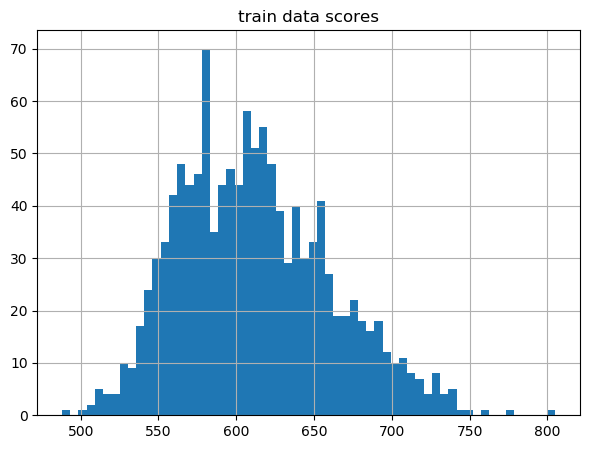

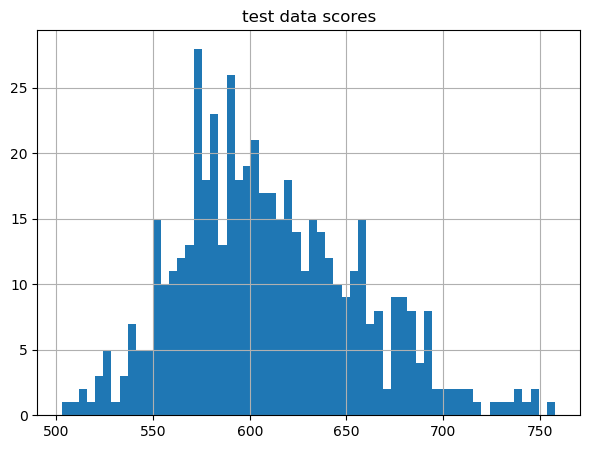

In [74]:
# sample code

# credit score for samples in test and train
train_score = sc.scorecard_ply(train, card)
test_score = sc.scorecard_ply(test, card)

#distrubution of scores on test data
train_score.hist(figsize=(7,5),bins=60)
plt.title('train data scores')
test_score.hist(figsize=(7,5),bins=60)
plt.title('test data scores')

**Calculate Percentage Correctly Classified measures on LR model**

In [75]:
# sample code
# print evaluation metrics of the model
y_pred = lr.predict(X_test)

print("Confusion matrix:")
print(confusion_matrix(y_pred, y_test))
print("\nPCC measures:")
print(classification_report(y_pred, y_test))



Confusion matrix:
[[474  37]
 [  1   2]]

PCC measures:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       511
           1       0.05      0.67      0.10         3

    accuracy                           0.93       514
   macro avg       0.52      0.80      0.53       514
weighted avg       0.99      0.93      0.96       514



**Evaluate the performance of logistic regression model with ROC**

Generate the ROC and calculate the AUC for the model using the scorecardpy methods. 

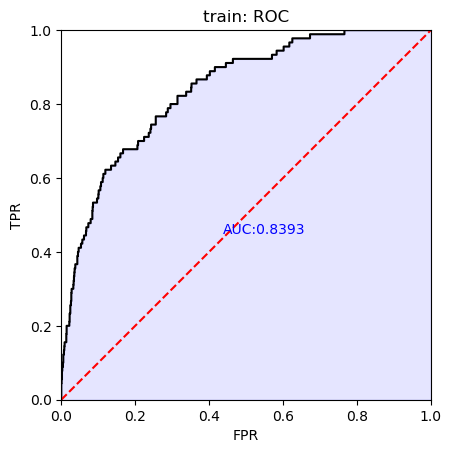

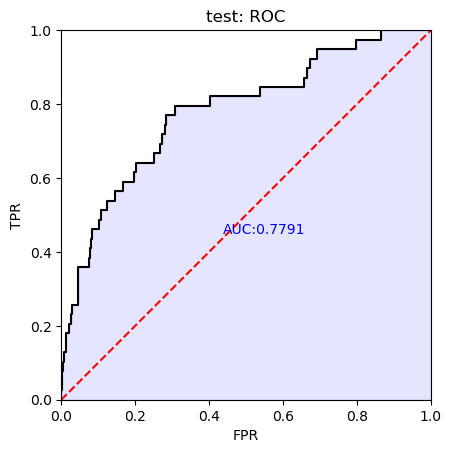

In [76]:
# sample code 

# evaluate the performance of the logistic regression
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf = sc.perf_eva(y_train, train_pred, plot_type=['roc'], title = "train")
test_perf = sc.perf_eva(y_test, test_pred, plot_type=['roc'], title = "test")

**Evaluate the performance of logistic regression model with ROC**

1. Go to where WOE and IV are calculated and find which variables have weak IV.  *Hint: check bin_iv column where <0.1*

2. Look at the scorecard and check what the difference in points bretween the range of values for those variables.  What is the largest range difference?

3. Go back to where MORTDUE was dropped and also drop the weak IV variables there, rerun the model and performance evaluation.  How did dropping those variable have a significant affect the model's performance?  
